##Problem statement: 
####To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [ ]:
#Library for data manipulation
import pandas as pd
#Library for scientific calculation
import numpy as np

#libraries for data visulalization
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
#library for getting path
import pathlib
# library to interact with os
import os

#modules and libraries to build ML model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


Now lets mount google drive 

In [ ]:
 # mount the google drive
 from google.colab import drive
 drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# change directory
#os.chdir('gdrive/My Drive') 
# unzip the file to get dataset images
!unzip CNN_assignment.zip

Archive:  CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer ISIC The I

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
# Path for train data
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
# Path for test data
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test/")


Now lets see number of images in each set.

In [ ]:
# get no of images in train folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
# get no of images in test folder
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


The no of images is as expected and the dataset has been imported.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
# no of images 
batch_size = 32
# size to which image to be resized
img_height = 180
img_width = 180

Now we will get train dataset and validation dataset as per above specified parameters and use 80% of the images for training, and 20% for validation.

In [ ]:
# get train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# get validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Lets create a code to visualize one instance of all the nine classes present in the dataset

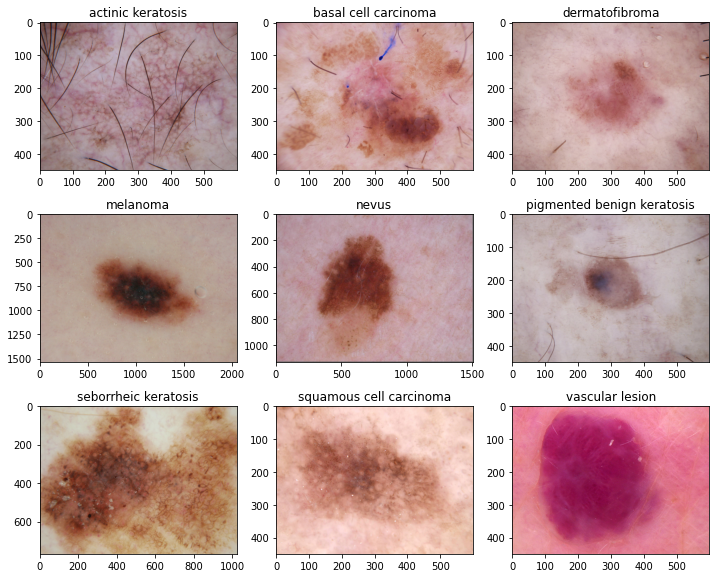

In [ ]:
import matplotlib.pyplot as plt

#code to to visualize
# set figure size
plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  # get one image per class
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  # set title as class name
  plt.title(class_names[i])
  # show image
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
# setup for better memory utilisation
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Lets create a CNN model, which can accurately detect 9 classes present in the dataset. We will use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

We will use convolution layers that extract features and then max pooling.
We will use padding same to ensure the image shape retain same size which ensure no loss of information due to compression.
Activation is Relu for all layers except last layer to avoid exploding and vanishing gradient problems.
As per convention, no of filters are powers of 2.

In [ ]:
# create custom model
model_1 =Sequential()

# scaling the pixel values to 0-1 range
model_1.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 16 filters, 3x3 filter and relu activation with Max pooling
model_1.add(layers.Conv2D(16,(3,3),padding = 'same',activation='relu'))
model_1.add(layers.MaxPooling2D())

# Convolution layer with 32 filters, 3x3 filter and relu activation with Max pooling
model_1.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model_1.add(layers.MaxPooling2D())

# Convolution layer with 64 filters, 3x3 filter and relu activation with Max pooling
model_1.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model_1.add(layers.MaxPooling2D())

# flatten the output before dense layer
model_1.add(layers.Flatten())
model_1.add(layers.Dense(128,activation='relu'))
# neurons in last layer is no of classes and softmax due to multi class classification
model_1.add(layers.Dense(9,activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

Optimizer is "Adam" is an adaptive learning rate optimization algorithm that utilises both momentum and scaling, combining the benefits of  both RMSProp and SGD with momentum. Also it is memory efficient and has less no of parameters to tune.

Loss is categorical loss as it is classification task. And SparseCategoricalCrossentropy is used as labels are encoded are intergers.
This is so because when we use tf.keras.preprocessing.image_dataset_from_directory to load images, the default label_mode ="int".

In [ ]:
#Chooaing an appropirate optimiser and loss function
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 64)       

### Train the model

Now lets train the model.

In [ ]:
# set no of epochs
epochs = 20
# train model with train and validation data.
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose =2
)

Epoch 1/20
56/56 - 5s - loss: 2.0779 - accuracy: 0.2204 - val_loss: 1.8811 - val_accuracy: 0.3400 - 5s/epoch - 98ms/step
Epoch 2/20
56/56 - 0s - loss: 1.7170 - accuracy: 0.3968 - val_loss: 1.5150 - val_accuracy: 0.4966 - 483ms/epoch - 9ms/step
Epoch 3/20
56/56 - 0s - loss: 1.4935 - accuracy: 0.4710 - val_loss: 1.4313 - val_accuracy: 0.5123 - 482ms/epoch - 9ms/step
Epoch 4/20
56/56 - 0s - loss: 1.3292 - accuracy: 0.5312 - val_loss: 1.3677 - val_accuracy: 0.5503 - 482ms/epoch - 9ms/step
Epoch 5/20
56/56 - 0s - loss: 1.2644 - accuracy: 0.5608 - val_loss: 1.4062 - val_accuracy: 0.5235 - 481ms/epoch - 9ms/step
Epoch 6/20
56/56 - 0s - loss: 1.1704 - accuracy: 0.5988 - val_loss: 1.3766 - val_accuracy: 0.5481 - 481ms/epoch - 9ms/step
Epoch 7/20
56/56 - 0s - loss: 1.0713 - accuracy: 0.6189 - val_loss: 1.4048 - val_accuracy: 0.5324 - 482ms/epoch - 9ms/step
Epoch 8/20
56/56 - 0s - loss: 1.0894 - accuracy: 0.6144 - val_loss: 1.3690 - val_accuracy: 0.5391 - 482ms/epoch - 9ms/step
Epoch 9/20
56/56 -

### Visualizing training results

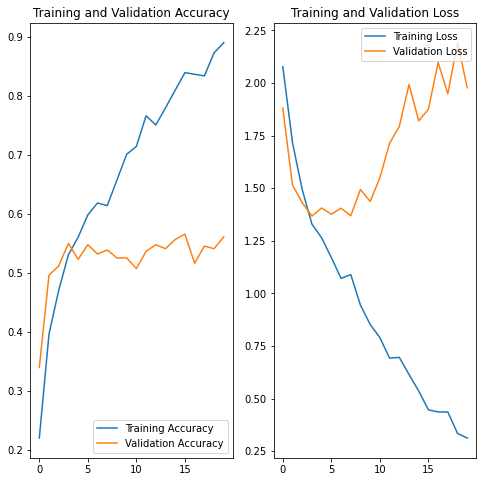

In [ ]:
# get accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plot train and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot train and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Findings
#### 1) The training accuracy increases to a good 89% but the validation accuracy increases but stalled to around 56% in training.
#### 2) The validation loss though follows the training loss for initial few epochs but increases drastically even though training loss keeps on falling.

####The large and noticible difference between training and validation accuracy shows that the model has clearly overfitted. The model was unable to learn generalised patterns in train data and has just memorised the train data which lead to poor performance on unseen validation data.
####The dataset is too small to learn general patterns and/or the model is too complex for the data.

### Model 2

####So we will use 2 strategies
####1) increase the dataset by choosing an appropriate data augumentation strategy
####2) reduce model complexity using Dropout layers in the model.

Lets first create an augmentation layer which will do augment operations to create more images of same class.

In [ ]:
# create data augmentation layer
data_augmentation = keras.Sequential(
  [ 
    # flip images horizontally
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
   #  roate image by 0.1
    layers.RandomRotation(0.1),
   #  randomly zoom by 0.1
    layers.RandomZoom(0.1),
  ]
)

Now lets see if the augmentation works.

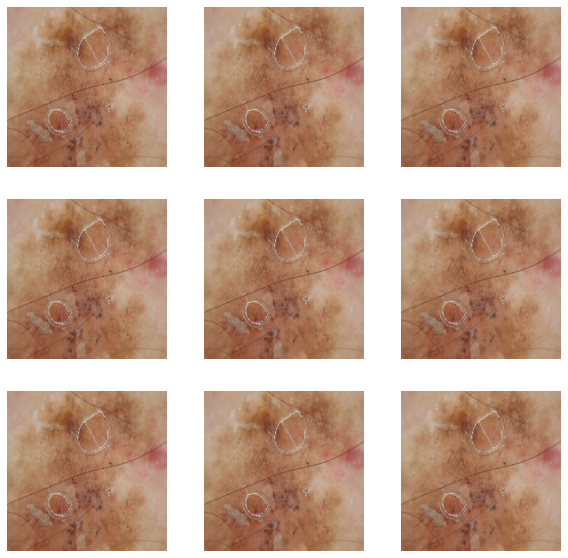

In [ ]:
# visualize how  augmentation strategy works for one instance of training image.
# fig size
plt.figure(figsize=(10, 10))
# take one image in the batch
for images, _ in train_ds.take(1):
  for i in range(9):
    # create augmented image
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

So augmentation has worked as all images are augmented and are of same class.

### Modelling
####Now we create new added which has the extra augmentation layer and also include dropout layers. We use this as there was clear sign of overfit.


In [ ]:
# create custom model
model_2 =Sequential()

# scaling the pixel values to 0-1 range
model_2.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
# data augmentation layer
model_2.add(data_augmentation)

# Convolution layer with 16 filters, 3x3 filter and relu activation with Max pooling
model_2.add(layers.Conv2D(16,(3,3),padding = 'same',activation='relu'))
model_2.add(layers.MaxPooling2D())

# Convolution layer with 32 filters, 3x3 filter and relu activation with Max pooling
model_2.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model_2.add(layers.MaxPooling2D())

# Convolution layer with 64 filters, 3x3 filter and relu activation with Max pooling
model_2.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model_2.add(layers.MaxPooling2D())

#adding a 20% dropout 
model_2.add(layers.Dropout(0.2))

# flatten the output before dense layer
model_2.add(layers.Flatten())
model_2.add(layers.Dense(128,activation='relu'))
# neurons in last layer is no of classes and softmax due to multi class classification
model_2.add(layers.Dense(9,activation='softmax'))


### Compiling the model

In [ ]:
# compile model
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# show model summary
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_8 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model

In [ ]:
# train your model for 20 epochs
epochs = 20
# fit model on train and validation data
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 25ms/step - loss: 2.0408 - accuracy: 0.2589 - val_loss: 1.8338 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6712 - accuracy: 0.4040 - val_loss: 1.5492 - val_accuracy: 0.4631
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4789 - accuracy: 0.4838 - val_loss: 1.4050 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4066 - accuracy: 0.5151 - val_loss: 1.3852 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3403 - accuracy: 0.5307 - val_loss: 1.3343 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2824 - accuracy: 0.5435 - val_loss: 1.4286 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3151 - accuracy: 0.5352 - val_loss: 1.4094 - val_accuracy: 0.5280
Epoch 8/20
56

### Visualizing the results

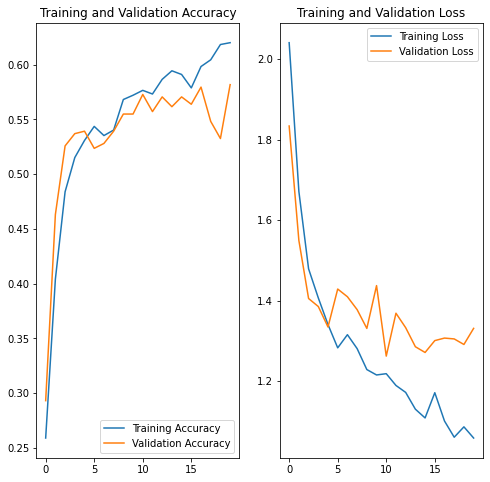

In [ ]:
# calculate accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plot train and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot train and validation losses
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Findings
####- The training accuracy after 20 epochs is 62% which is much closer to the validation accuracy of 58% than the previous model.

####Hence this model is a better fit than previous model as model seems to have generalised the patterns in the data as seen from similar performaces on train and validataion data. 

####Though the overfit has been reduced , but the accuracy of the model still seems to be low. Lets analyse distribution of classes in the training dataset.


###Distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#count number of image in each classes
count= []
# iterate over directory
for path in pathlib.Path(data_dir_train).iterdir():
  if path.is_dir():
    count.append(len([name for name in os.listdir(path)
              if os.path.isfile(os.path.join(path, name))]))
    
#get name of the classes
sub_directory = [name for name in os.listdir(data_dir_train)
          if os.path.isdir(os.path.join(data_dir_train, name))]

# create data frame of no of images and name of classes
df=  pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])
print(df)


                        Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           438
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           139


Lets also visualise the class distribution.

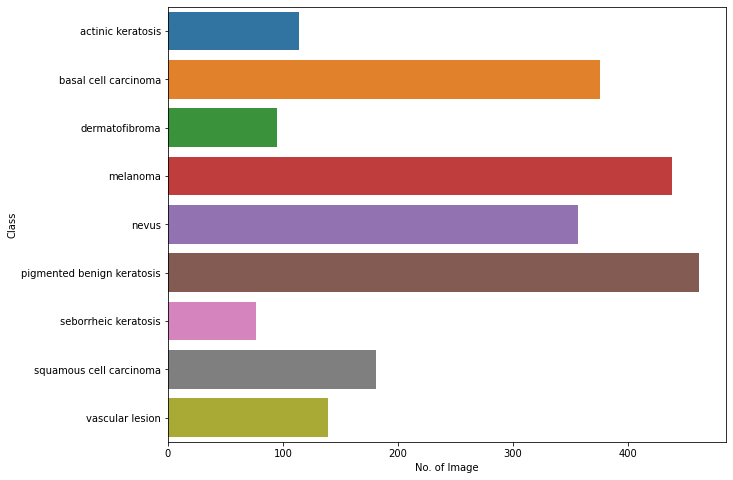

In [ ]:
#Visualize the no of images in each class.
# barplot images in each class
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

###Findings
####We see that there is clear class imbalance in train data.
#### - Which class has the least number of samples?
####"Seborrheic keratosis" has least no of samples.(77)
#### - Which classes dominate the data in terms proportionate number of samples?
####"Pigmented benign keratosis" has dominate the data with most no of images.(462)


#### Rectify the class imbalance
### We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples. Lets install the package.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# path to initial train data
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
# import package
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    # define augmentation operations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    #adding 500 samples per class to make sure that none of the classes are sparse.
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8D00A2CFA0>: 100%|██████████| 500/500 [00:04<00:00, 122.49 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8BE973FCD0>: 100%|██████████| 500/500 [00:04<00:00, 117.95 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8BE9532820>: 100%|██████████| 500/500 [00:04<00:00, 101.61 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2597x2185 at 0x7F8BE9BA6A60>: 100%|██████████| 500/500 [00:17<00:00, 28.81 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8CF22342B0>: 100%|██████████| 500/500 [00:14<00:00, 34.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8CF21F9F10>: 100%|██████████| 500/500 [00:04<00:00, 123.96 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8C1A054400>: 100%|██████████| 500/500 [00:07<00:00, 66.95 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8C704FFDF0>: 100%|██████████| 500/500 [00:04<00:00, 123.38 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8BE986B760>: 100%|██████████| 500/500 [00:04<00:00, 124.15 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
# total no of augmented images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

We see that new augmented images are created in each class folder in separate "output" folder.
Lets create path list and class names of original images and augmented images. Both will be combined to create new augmented dataset.

In [ ]:
from glob import glob
# path of original train images
path_list_original =  [x for x in glob(os.path.join(data_dir_train, '*/*.jpg'))]
# class names original train images
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*/*.jpg'))]
# create dictionary path and classnames
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))

# path of augmented train images
path_list_new =  [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# class names augmented train images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# create dictionary of path and classnames
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))



Lets create new train dataset by combining original and augmented images.

In [ ]:
# create dataframe for original images with path and labels
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
# create dataframe for augmented images with path and labels
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# combine to create new dataset path and labels
new_df = original_df.append(df2)

Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
# no of images in each class of new dataset
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [ ]:
# set parameters for the model
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
# path of new original+augmented dataset
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
# get tarin dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [ ]:
# get validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create model 

The model remains same. Only new dataset is changed by adding augmented images to improve class balance.

In [ ]:
# create custom model
model_2 =Sequential()

# scaling the pixel values to 0-1 range
model_2.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
# data augmentation layer
model_2.add(data_augmentation)

# Convolution layer with 16 filters, 3x3 filter and relu activation with Max pooling
model_2.add(layers.Conv2D(16,(3,3),padding = 'same',activation='relu'))
model_2.add(layers.MaxPooling2D())

# Convolution layer with 32 filters, 3x3 filter and relu activation with Max pooling
model_2.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model_2.add(layers.MaxPooling2D())

# Convolution layer with 64 filters, 3x3 filter and relu activation with Max pooling
model_2.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model_2.add(layers.MaxPooling2D())

#adding a 20% dropout 
model_2.add(layers.Dropout(0.2))

# flatten the output before dense layer
model_2.add(layers.Flatten())
model_2.add(layers.Dense(128,activation='relu'))
# neurons in last layer is no of classes and softmax due to multi class classification
model_2.add(layers.Dense(9,activation='softmax'))


#### Compile model 

In [ ]:
## compile model
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# show model summary
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_8 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

####  Train the model

In [ ]:
# no of epochs
epochs = 30
# fit model on train and validation data
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 11s 59ms/step - loss: 2.0258 - accuracy: 0.2385 - val_loss: 1.6198 - val_accuracy: 0.3794
Epoch 2/30
169/169 [==============================] - 10s 58ms/step - loss: 1.5490 - accuracy: 0.3935 - val_loss: 1.4523 - val_accuracy: 0.4395
Epoch 3/30
169/169 [==============================] - 10s 58ms/step - loss: 1.4006 - accuracy: 0.4633 - val_loss: 1.3081 - val_accuracy: 0.5063
Epoch 4/30
169/169 [==============================] - 10s 58ms/step - loss: 1.3253 - accuracy: 0.4935 - val_loss: 1.3743 - val_accuracy: 0.4885
Epoch 5/30
169/169 [==============================] - 10s 58ms/step - loss: 1.2753 - accuracy: 0.5104 - val_loss: 1.1960 - val_accuracy: 0.5434
Epoch 6/30
169/169 [==============================] - 10s 58ms/step - loss: 1.2074 - accuracy: 0.5356 - val_loss: 1.2059 - val_accuracy: 0.5382
Epoch 7/30
169/169 [==============================] - 10s 59ms/step - loss: 1.1578 - accuracy: 0.5694 - val_loss: 1.1220 - val_accuracy:

####  Visualize the model results

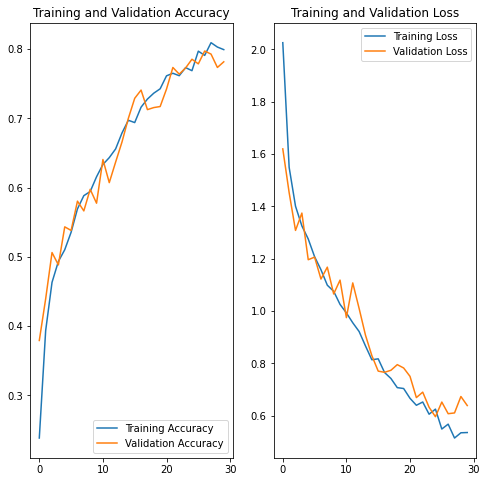

In [ ]:
# calculate loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot training and validation losses

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Note : no of epochs
There is discrepency on no of epochs to use: the starter code had set no of epochs to 30 while it is 20 in evaluation rubic.
As discussed in preassigment session, no of epochs are set whichever gives better accuracy model.
Since my model at 30 epochs had better accuracy, no of epochs is set as 30 here. 


###Analyze results
####- The model accuracy has improved to 80% which is much better than previous. The train and validation losses have also considerably reduced.
####- The difference between training accuracy(80%) and validation accuracy(77%) has also decreased drastically and difference is acceptable range.

####Hence the model is now good fit as it gives similar accuracy on unseen validation data as well.

####The class rebalance has reduced overfit as well as improved overall accuracy of the model.



###Prediction on test set

Lets see the prediction of the model on unseen test images. Since the task is melonoma detection, we will use image of "melonona" class to test the model.

1/1 [==============================] - 0s 76ms/step
Actual Class melanoma
Predictive Class melanoma


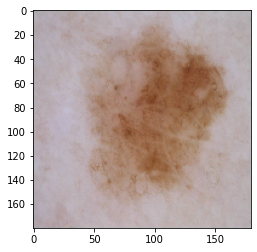

In [ ]:
from glob import glob
# to load images 
from tensorflow.keras.preprocessing.image import load_img
# get path of a melanoma test image
image_path = os.path.join(data_dir_test, class_names[3], '*')
image = glob(image_path)
# load image and resize
image = load_img(image[-1],target_size=(180,180,3))
# show image
plt.imshow(image)
plt.grid(False)

# add batch dimension
img = np.expand_dims(image,axis=0)
# prediction using model
pred = model_2.predict(img)
# find max pron=bability class
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[3] +'\n'+ "Predictive Class "+pred_class )

As expected the melanona class image was classified accurately.